In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import warnings

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# Load datasets
flights = pd.read_csv('data/ontime.csv')
flights

,year,quarter,month,dayofmonth,dayofweek,flightdate,reporting_airline,dot_id_reporting_airline,iata_code_reporting_airline,tail_number,flight_number_reporting_airline,originairportid,originairportseqid,origincitymarketid,origin,origincityname,originstate,originstatefips,originstatename,originwac,destairportid,destairportseqid,destcitymarketid,dest,destcityname,deststate,deststatefips,deststatename,destwac,crsdeptime,deptime,depdelay,depdelayminutes,depdel15,departuredelaygroups,deptimeblk,taxiout,wheelsoff,wheelson,taxiin,crsarrtime,arrtime,arrdelay,arrdelayminutes,arrdel15,arrivaldelaygroups,arrtimeblk,cancelled,cancellationcode,diverted,crselapsedtime,actualelapsedtime,airtime,flights,distance,distancegroup,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay,firstdeptime,totaladdgtime,longestaddgtime,divairportlandings,divreacheddest,divactualelapsedtime,divarrdelay,divdistance,divairport
0,2013,1,1,27,7,2013-01-27,9E,20363,9E,N907XJ,3341,11298,1129803,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,13487,1348702,31650,MSP,"Minneapolis, MN",MN,27,Minnesota,63,1821,1823,2,2,0,0,1800-1859,21,1844,2041,16,2049,2057,8,8,0,0,2000-2059,0,0,0,148,154,117,1,852,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2013,1,1,28,1,2013-01-28,9E,20363,9E,N923XJ,3341,11298,1129803,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,13487,1348702,31650,MSP,"Minneapolis, MN",MN,27,Minnesota,63,1821,1900,39,39,1,2,1800-1859,16,1916,2104,6,2049,2110,21,21,1,1,2000-2059,0,0,0,148,130,108,1,852,4,0,0,0,0,21,0,0,0,0,0,0,0,0,0
2,2013,1,1,29,2,2013-01-29,9E,20363,9E,N912XJ,3341,11298,1129803,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,13487,1348702,31650,MSP,"Minneapolis, MN",MN,27,Minnesota,63,1821,1947,86,86,1,5,1800-1859,17,2004,2136,5,2049,2141,52,52,1,3,2000-2059,0,0,0,148,114,92,1,852,4,0,0,0,0,52,0,0,0,0,0,0,0,0,0
3,2013,1,1,30,3,2013-01-30,9E,20363,9E,N931XJ,3341,11298,1129803,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,13487,1348702,31650,MSP,"Minneapolis, MN",MN,27,Minnesota,63,1821,1859,38,38,1,2,1800-1859,12,1911,2106,8,2049,2114,25,25,1,1,2000-2059,0,0,0,148,135,115,1,852,4,0,0,0,0,25,0,0,0,0,0,0,0,0,0
4,2013,1,1,31,4,2013-01-31,9E,20363,9E,N919XJ,3341,11298,1129803,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,13487,1348702,31650,MSP,"Minneapolis, MN",MN,27,Minnesota,63,1821,1906,45,45,1,3,1800-1859,19,1925,2118,5,2049,2123,34,34,1,2,2000-2059,0,0,0,148,137,113,1,852,4,4,0,0,0,30,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498082,2013,1,1,8,2,2013-01-08,WN,19393,WN,N725SW,3758,11292,1129202,30325,DEN,"Denver, CO",CO,8,Colorado,82,12892,1289203,32575,LAX,"Los Angeles, CA",CA,6,California,91,1215,1220,5,5,0,0,1200-1259,26,1246,1336,7,1340,1343,3,3,0,0,1300-1359,0,0,0,145,143,110,1,862,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
498083,2013,1,1,8,2,2013-01-08,WN,19393,WN,N409WN,389,11292,1129202,30325,DEN,"Denver, CO",CO,8,Colorado,82,12953,1295302,31703,LGA,"New York, NY",NY,36,New York,22,1155,1211,16,16,1,1,1100-1159,8,1219,1733,7,1735,1740,5,5,0,0,1700-1759,0,0,0,220,209,194,1,1620,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0
498084,2013,1,1,8,2,2013-01-08,WN,19393,WN,N294WN,2782,11292,1129202,30325,DEN,"Denver, CO",CO,8,Colorado,82,12953,1295302,31703,LGA,"New York, NY",NY,36,New York,22,1655,1717,22,22,1,1,1600-1659,8,1725,2223,5,2235,2228,-7,0,0,-1,2200-2259,0,0,0,220,191,178,1,1620,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0
498085,2013,1,1,8,2,2013-01-08,WN,19393,WN,N600WN,268,11292,1129202,30325,DEN,"Denver, CO",CO,8,Colorado,82,13198,1319801,33198,MCI,"Kansas City, MO",MO,29,Missouri,64,1850,1853,3,3,0,0,1800-1859,16,1909,2119,5,2120,2124,4,4,0,0,2100-2159,0,0,0,90,91,70,1,533,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
aircraft = pd.read_csv('data/aircraft.csv')
aircraft

,tail_number,manufacturer,model
0,N789SW,Boeing,B-737-7H4
1,N198UW,Airbus,A321-211
2,N681UP,Boeing,B747-1
3,N54711,Boeing,B737-700PAX
4,N390SW,Boeing,B-737-3H4
...,...,...,...
13096,N923TW,McDonnell-Douglas,SUPER80PASSENGER
13097,N379WN,Boeing,737-300PASSENGERONLY
13098,N821NN,Boeing,B737-823PASSENGER
13099,N247LR,Bombardier,CRJ-900-PSGR


In [4]:
airport = pd.read_csv('data/airport_id.csv')
airport

,code,description
0,11712,"Greven, Germany: Munster/Osnabruck"
1,11713,"Fort Madison, IA: Fort Madison Municipal"
2,11714,"Fort Myers, FL: Page Field"
3,11715,"Freetown, Sierra Leone: Freetown Lungi"
4,11716,"Funchal, Portugal: Madeira"
...,...,...
6245,12878,"Lafayette, IN: Purdue University"
6246,12879,"Lannion, France: Lannion Airport"
6247,12880,"Lages, Brazil: Lages Airport"
6248,12881,"Aklavik, Canada: Aklavik Airport"


In [5]:
# # Filter for flights heading to Chicago
# flights = flights[flights['destcityname'].str.contains("Chicago")]

# Creating a categorical delay feature
def categorize_delay(x):
    if x <= 10:
        return 'on-time'
    else:
        return 'delayed'

flights['delay_category'] = flights['arrdelay'].apply(categorize_delay)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression


# Time of day from CRSDepTime
flights['hour_of_day'] = flights['crsdeptime'] // 100

# Day of week and month from flightdate
flights['flightdate'] = pd.to_datetime(flights['flightdate'])
flights['day_of_week'] = flights['flightdate'].dt.dayofweek
flights['month'] = flights['flightdate'].dt.month

flights = pd.merge(flights, aircraft[['tail_number', 'manufacturer']], on='tail_number', how='left')

# Encoding categorical variables
encoder = OneHotEncoder(sparse=False)
categorical_features = flights[['reporting_airline', 'hour_of_day', 'day_of_week', 'month', 'manufacturer']]
categorical_encoded = encoder.fit_transform(categorical_features)

# Combining encoded features back into the main dataframe
encoded_features = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names(categorical_features.columns))
flights = pd.concat([flights.reset_index(drop=True), encoded_features], axis=1)

In [7]:
# Selecting features and target variable
features = list(encoded_features.columns)  # Add any other numerical features deemed necessary
X = flights[features]
y = flights['delay_category']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Training the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)  # Increased max_iter for convergence
model.fit(X_train, y_train)

# Predictions and evaluating the model
y_pred = model.predict(X_test)

# Evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

     delayed       0.00      0.00      0.00     31295
     on-time       0.79      1.00      0.88    118132

    accuracy                           0.79    149427
   macro avg       0.40      0.50      0.44    149427
weighted avg       0.62      0.79      0.70    149427

Confusion Matrix:
[[     0  31295]
 [     0 118132]]
Accuracy: 0.7905666311978424


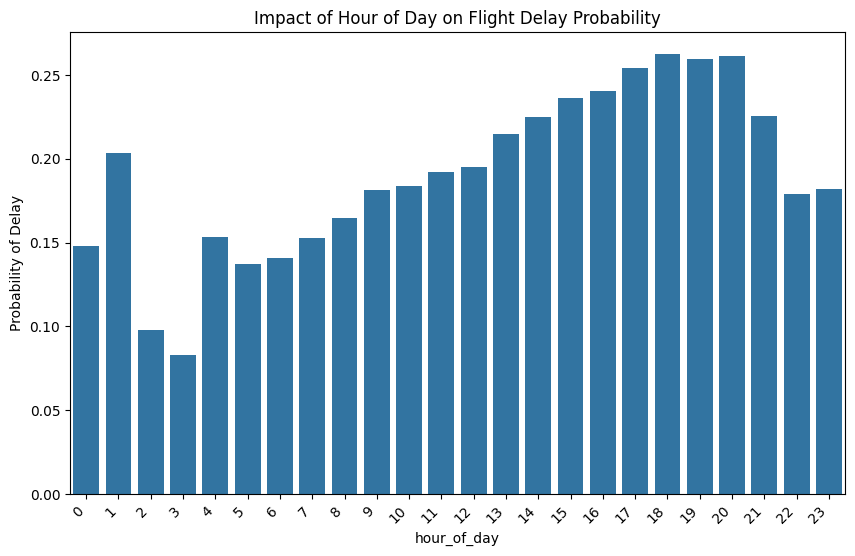

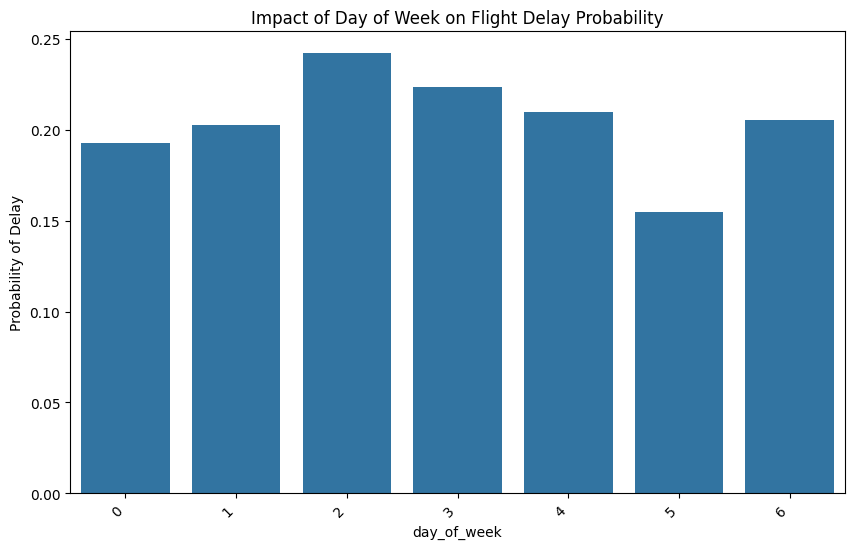

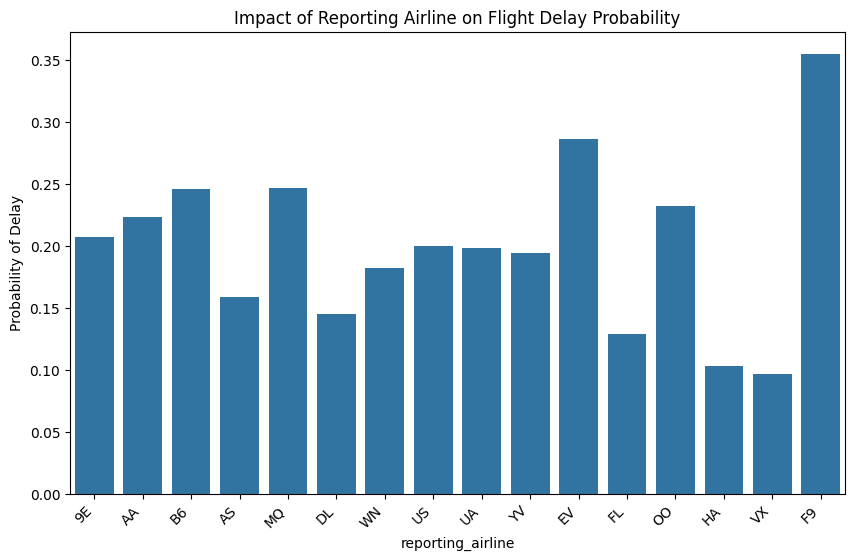

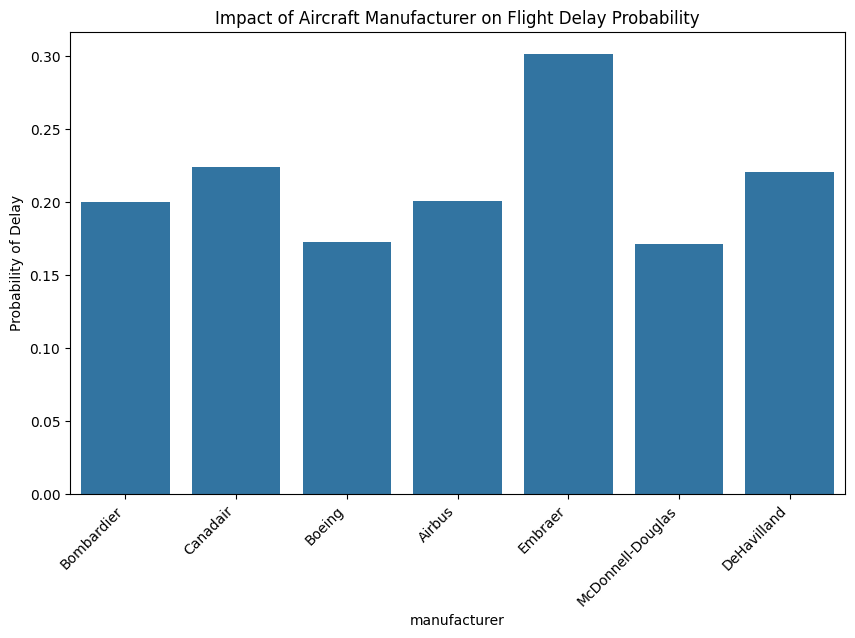

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Predict probabilities
probabilities = model.predict_proba(X)[:, 0]  # get the probability of the 'delayed' class
flights['delay_probability'] = probabilities

# Step 2: Plotting the impact of each feature

# Define a function to plot the impact of categorical features on delay probability
def plot_feature_impact(df, feature_name, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_name, y='delay_probability', data=df, ci=None)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(feature_name)
    plt.ylabel('Probability of Delay')
    plt.title(title)
    plt.show()

# Plot for 'hour_of_day'
plot_feature_impact(flights, 'hour_of_day', 'Impact of Hour of Day on Flight Delay Probability')

# Plot for 'day_of_week'
plot_feature_impact(flights, 'day_of_week', 'Impact of Day of Week on Flight Delay Probability')

# Plot for 'reporting_airline'
plot_feature_impact(flights, 'reporting_airline', 'Impact of Reporting Airline on Flight Delay Probability')

# Plot for 'manufacturer'
plot_feature_impact(flights, 'manufacturer', 'Impact of Aircraft Manufacturer on Flight Delay Probability')


In [9]:
# Step 1: Define the flight's features (ensure you input the correct feature values)
example_flight_info = {
    'reporting_airline': 'AA',  # Example airline
    'hour_of_day': 15,          # Example hour of day (3 PM)
    'day_of_week': 2,           # Example day (Tuesday)
    'month': 1,                 # Example month (January)
    'manufacturer': 'Boeing'    # Example manufacturer
}

# Convert to DataFrame
example_flight = pd.DataFrame([example_flight_info])

# Step 2: Preprocess the flight information
# (Assuming encoder is your fitted OneHotEncoder from the earlier preprocessing)
# Here we need to apply the same preprocessing to this single example.
# It's critical that this transformation is consistent with the original training data preprocessing.

# For categorical features, use the same encoder to transform
categorical_features = example_flight[['reporting_airline', 'hour_of_day', 'day_of_week', 'month', 'manufacturer']]
categorical_encoded = encoder.transform(categorical_features)

# For numerical features, apply the same scaling or transformations as used in training

# Combine with the rest of your features (we assume all other necessary features are numeric and do not require encoding)

# Step 3: Predict the probability of delay for the example flight
# Note: 'model' should be your trained LogisticRegression model
example_encoded_features = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names(categorical_features.columns))
probability_of_delay = model.predict_proba(example_encoded_features)[:, 0][0]  # Get the probability for 'delayed' class

# Step 4: Present the probability
print(f"The predicted probability of the flight being delayed is: {probability_of_delay:.2f}")

The predicted probability of the flight being delayed is: 0.34
